In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import *

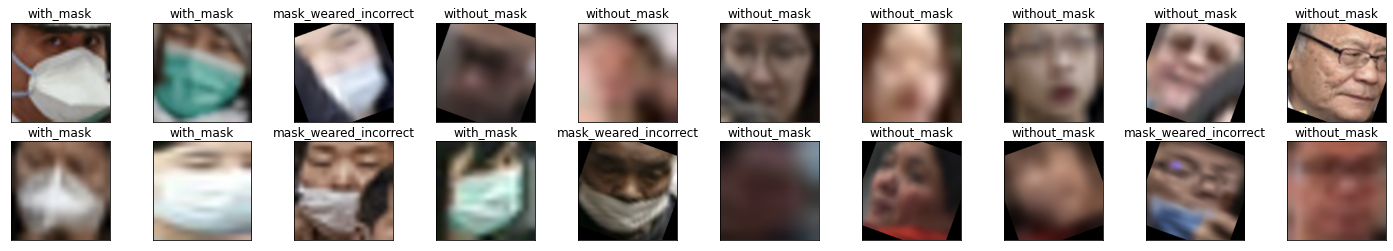

In [2]:
# file path of training, validating and testing data in Google drive
train_path = 'C:\\Users\\jerry\\Downloads\\aps360\\better_augmented\\training'
val_path = 'C:\\Users\\jerry\\Downloads\\aps360\\better_augmented\\validation'
test_path = 'C:\\Users\\jerry\\Downloads\\aps360\\better_augmented\\testing'

# transform setting
transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor()])

# Load data from Google Drive
train_set = torchvision.datasets.ImageFolder(train_path, transform=transform)
val_set = torchvision.datasets.ImageFolder(val_path, transform=transform)
test_set = torchvision.datasets.ImageFolder(test_path, transform=transform)
# overfit_set = torchvision.datasets.ImageFolder(overfit_path, transform=transform)

# Verification Step - obtain one batch of images
dataiter = iter(torch.utils.data.DataLoader(train_set, batch_size=27, num_workers=1, shuffle=True))
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ['mask_weared_incorrect', 'with_mask', 'without_mask']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [4]:
class mask_detection(nn.Module):
    def __init__(self):
        super(mask_detection, self).__init__()
        self.name = "mask_detection"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [5]:
def get_accuracy(model, data_loader):
  
  # for the later dropout model, use this to flag testing mode
  #model.eval()
  
  correct = 0
  total = 0
  for imgs, labels in data_loader:

    # enable GPU
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()

    output = model(imgs)

    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
  return correct / total

In [6]:
def train(model, train_set, val_set, batch_size=32, num_epochs=1, learning_rate=0.001, validation=True, transfer=False):
  num_workers = 1
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

  torch.manual_seed(1000)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  epochs, losses, iters, train_acc, val_acc = [], [], [], [], []
  
  # training
  print ("Training Started...")
  start_time = time.time()
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
    for imgs, labels in iter(train_loader):
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      if not transfer:
        out = model(imgs)             # forward pass
        loss = criterion(out, labels) # compute the total loss
      else:                           # use softmax activation if training tranfer learning model
        out = model(imgs)
        prob = F.softmax(out, dim=1)
        loss = criterion(prob, labels)
      losses.append(loss)
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch
      n += 1
      iters.append(n)

    # save the current training information    
    #losses.append(float(loss)/batch_size)             # compute *average* loss
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
    if validation: val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
    epochs.append(epoch)
    if validation:
      print(("Epoch {}: Training Accuracy {} |"+"Validation Accuracy {}").format(epoch, train_acc[epoch], val_acc[epoch]))
    else:
      print(("Epoch {}: Training Accuracy {}").format(epoch, train_acc[epoch]))
    
  end_time = time.time()      
  
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  if validation: plt.plot(epochs, val_acc, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  if validation: print("Final Validation Accuracy: {}".format(val_acc[-1]))
  print("The model took {:.2f} seconds to train".format(end_time - start_time))   
  return

In [8]:
def evaluate(model, test_set):
    model.eval()
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(test_set):
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

CUDA is available!  Training on GPU ...
Training Started...
Epoch 0: Training Accuracy 0.8469626168224299 |Validation Accuracy 0.8052959501557633
Epoch 1: Training Accuracy 0.8915220293724967 |Validation Accuracy 0.8613707165109035
Epoch 2: Training Accuracy 0.8878504672897196 |Validation Accuracy 0.883177570093458
Epoch 3: Training Accuracy 0.8958611481975968 |Validation Accuracy 0.8154205607476636
Epoch 4: Training Accuracy 0.9143858477970628 |Validation Accuracy 0.8691588785046729
Epoch 5: Training Accuracy 0.9212283044058746 |Validation Accuracy 0.8746105919003115
Epoch 6: Training Accuracy 0.9279038718291055 |Validation Accuracy 0.8777258566978193
Epoch 7: Training Accuracy 0.9384178905206942 |Validation Accuracy 0.868380062305296
Epoch 8: Training Accuracy 0.9462616822429907 |Validation Accuracy 0.8785046728971962
Epoch 9: Training Accuracy 0.9489319092122831 |Validation Accuracy 0.8753894080996885
Epoch 10: Training Accuracy 0.9566088117489987 |Validation Accuracy 0.866043613707

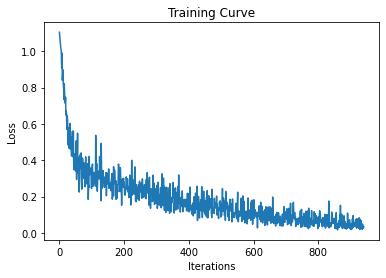

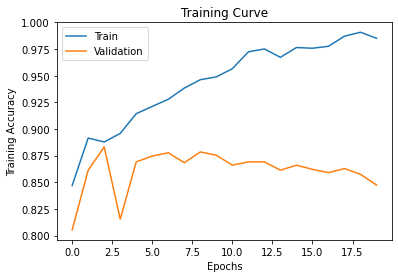

Final Training Accuracy: 0.9851468624833111
Final Validation Accuracy: 0.8473520249221184
The model took 737.26 seconds to train


In [11]:

# overfit_path = '/content/gdrive/My Drive/APS360/Lab3/Overfit'
# overfit_set = torchvision.datasets.ImageFolder(overfit_path, transform=transform)

model = mask_detection()

# enable GPU usage
use_cuda = True
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, train_set, val_set, batch_size=128, num_epochs=20, learning_rate=0.0005, validation=True)

In [12]:
test_accuracy = evaluate(model, test_set)
print("test_accuracy =".format(test_accuracy))

test_accuracy =


In [11]:
class dropout_CNN(nn.Module):
  def __init__(self):
    super(dropout_CNN, self).__init__()
    self.name = "dropout_CNN"
    self.conv1 = nn.Conv2d(256, 160, 5, padding=2) #in_channels, out_chanels, kernel_size
    self.fc1 = nn.Linear(360 * 4 * 4, 100)
    self.fc2 = nn.Linear(100, 3)
    self.dropout1 = nn.Dropout(0.2) # drop out layer with 20% dropped out neuron
    self.dropout2 = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = x.view(-1, 360 * 4 * 4) #flatten feature data
    x = F.relu(self.fc1(self.dropout1(x)))
    x = self.fc2(self.dropout2(x))
    return x

In [12]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\jerry/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth
100.0%


In [13]:
import os

In [16]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, 
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, 
                                           num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, 
                                            num_workers=1, shuffle=True)

loaders = [train_loader, val_loader, test_loader]
feature_paths = ['C:\\Users\\jerry\\Downloads\\aps360\\feature\\alexnet\\training\\', 
         'C:\\Users\\jerry\\Downloads\\aps360\\feature\\alexnet\\validation\\', 
         'C:\\Users\\jerry\\Downloads\\aps360\\feature\\alexnet\\testing\\']

# compute features using AlexNet and save them to google drive
for step in range(3):
  n = 0
  for imgs, label in loaders[step]:
    features = alexnet.features(imgs)
    features_tensor = torch.from_numpy(features.detach().numpy())
    feature_path = feature_paths[step] + str(classes[label])
    if not os.path.isdir(feature_path):
      os.mkdir(feature_path)
    torch.save(features_tensor.squeeze(0), feature_path + '/' + str(n) + '.tensor')
    n += 1

In [17]:
# prepare features path for data loader
feature_train_set = torchvision.datasets.DatasetFolder(feature_paths[0], loader=torch.load, extensions=('.tensor'))
feature_val_set = torchvision.datasets.DatasetFolder(feature_paths[1], loader=torch.load, extensions=('.tensor'))
feature_test_set = torchvision.datasets.DatasetFolder(feature_paths[2], loader=torch.load, extensions=('.tensor'))

CUDA is available!  Training on GPU ...
Training Started...
Epoch 0: Training Accuracy 0.8706608811748998 |Validation Accuracy 0.8154205607476636
Epoch 1: Training Accuracy 0.8918558077436582 |Validation Accuracy 0.8442367601246106
Epoch 2: Training Accuracy 0.9237316421895861 |Validation Accuracy 0.8551401869158879
Epoch 3: Training Accuracy 0.9359145527369827 |Validation Accuracy 0.8621495327102804
Epoch 4: Training Accuracy 0.9073765020026703 |Validation Accuracy 0.7928348909657321
Epoch 5: Training Accuracy 0.9457610146862483 |Validation Accuracy 0.8419003115264797
Epoch 6: Training Accuracy 0.9410881174899867 |Validation Accuracy 0.8387850467289719
Epoch 7: Training Accuracy 0.9429238985313751 |Validation Accuracy 0.8107476635514018
Epoch 8: Training Accuracy 0.9464285714285714 |Validation Accuracy 0.852803738317757
Epoch 9: Training Accuracy 0.9576101468624834 |Validation Accuracy 0.8372274143302181
Epoch 10: Training Accuracy 0.9445927903871829 |Validation Accuracy 0.82087227414

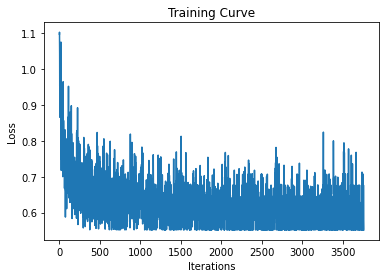

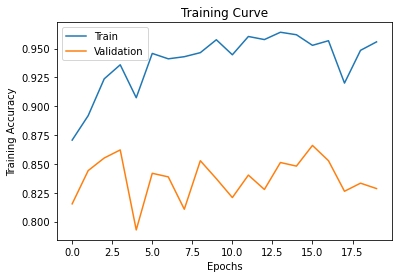

Final Training Accuracy: 0.9557743658210948
Final Validation Accuracy: 0.8286604361370716
The model took 156.34 seconds to train


In [18]:
drop_out_model = dropout_CNN()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  drop_out_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(drop_out_model, feature_train_set, feature_val_set, batch_size=32, num_epochs=20, learning_rate = 0.001, transfer=True)

CUDA is available!  Training on GPU ...
Training Started...
Epoch 0: Training Accuracy 0.5832777036048065 |Validation Accuracy 0.5623052959501558
Epoch 1: Training Accuracy 0.6398531375166889 |Validation Accuracy 0.6191588785046729
Epoch 2: Training Accuracy 0.6847463284379173 |Validation Accuracy 0.6292834890965732
Epoch 3: Training Accuracy 0.7565086782376502 |Validation Accuracy 0.6884735202492211
Epoch 4: Training Accuracy 0.807743658210948 |Validation Accuracy 0.7492211838006231
Epoch 5: Training Accuracy 0.8287716955941254 |Validation Accuracy 0.7827102803738317
Epoch 6: Training Accuracy 0.8503004005340454 |Validation Accuracy 0.7998442367601246
Epoch 7: Training Accuracy 0.8636515353805073 |Validation Accuracy 0.8045171339563862
Epoch 8: Training Accuracy 0.8731642189586115 |Validation Accuracy 0.8060747663551402
Epoch 9: Training Accuracy 0.8840120160213618 |Validation Accuracy 0.8138629283489096
Epoch 10: Training Accuracy 0.885347129506008 |Validation Accuracy 0.818535825545

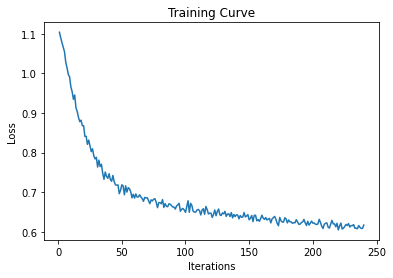

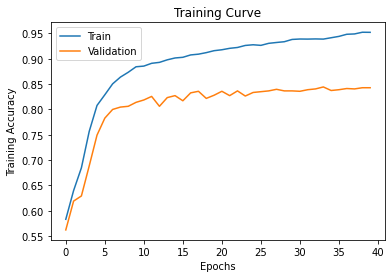

Final Training Accuracy: 0.951935914552737
Final Validation Accuracy: 0.8426791277258567
The model took 321.54 seconds to train


In [19]:
net4 = dropout_CNN()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  net4.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(net4, feature_train_set, feature_val_set, batch_size=1024, num_epochs=40, learning_rate = 0.0001, transfer=True)

CUDA is available!  Training on GPU ...
Training Started...
Epoch 0: Training Accuracy 0.7036048064085447 |Validation Accuracy 0.6495327102803738
Epoch 1: Training Accuracy 0.8302736982643525 |Validation Accuracy 0.7663551401869159
Epoch 2: Training Accuracy 0.8681575433911882 |Validation Accuracy 0.7967289719626168
Epoch 3: Training Accuracy 0.87716955941255 |Validation Accuracy 0.8185358255451713
Epoch 4: Training Accuracy 0.8951935914552737 |Validation Accuracy 0.8169781931464174
Epoch 5: Training Accuracy 0.9042056074766355 |Validation Accuracy 0.8208722741433022
Epoch 6: Training Accuracy 0.9062082777036048 |Validation Accuracy 0.8271028037383178
Epoch 7: Training Accuracy 0.9205607476635514 |Validation Accuracy 0.8247663551401869
Epoch 8: Training Accuracy 0.9255674232309746 |Validation Accuracy 0.8200934579439252
Epoch 9: Training Accuracy 0.92456608811749 |Validation Accuracy 0.8356697819314641
Epoch 10: Training Accuracy 0.929739652870494 |Validation Accuracy 0.838006230529595

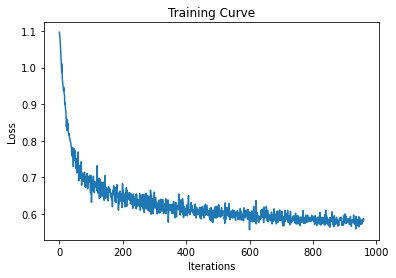

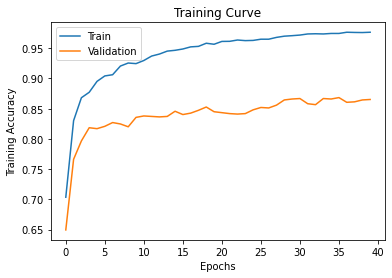

Final Training Accuracy: 0.9764686248331108
Final Validation Accuracy: 0.8652647975077882
The model took 314.47 seconds to train


In [20]:
net3 = dropout_CNN()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  net3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(net3, feature_train_set, feature_val_set, batch_size=256, num_epochs=40, learning_rate = 0.0001, transfer=True)

In [13]:
test_accuracy = evaluate(net3, test_set)
print("test_accuracy =".format(test_accuracy))

NameError: name 'net3' is not defined

CUDA is available!  Training on GPU ...
Training Started...
Epoch 0: Training Accuracy 0.45043391188251003 |Validation Accuracy 0.4657320872274143
Epoch 1: Training Accuracy 0.6214953271028038 |Validation Accuracy 0.5957943925233645
Epoch 2: Training Accuracy 0.7503337783711616 |Validation Accuracy 0.6892523364485982
Epoch 3: Training Accuracy 0.8170894526034713 |Validation Accuracy 0.7468847352024922
Epoch 4: Training Accuracy 0.8491321762349799 |Validation Accuracy 0.7429906542056075
Epoch 5: Training Accuracy 0.8686582109479306 |Validation Accuracy 0.7515576323987538
Epoch 6: Training Accuracy 0.8891855807743658 |Validation Accuracy 0.7523364485981309
Epoch 7: Training Accuracy 0.8976969292389854 |Validation Accuracy 0.7686915887850467
Epoch 8: Training Accuracy 0.9017022696929239 |Validation Accuracy 0.7764797507788161
Epoch 9: Training Accuracy 0.9107142857142857 |Validation Accuracy 0.7749221183800623
Epoch 10: Training Accuracy 0.9168891855807744 |Validation Accuracy 0.778816199

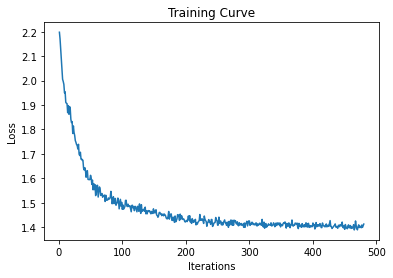

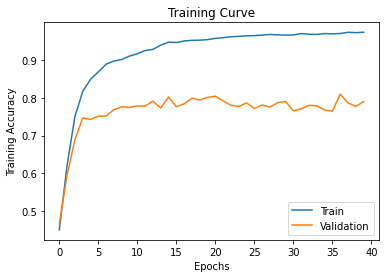

Final Training Accuracy: 0.9737983978638184
Final Validation Accuracy: 0.7904984423676013
The model took 909.36 seconds to train


In [ ]:
net2 = dropout_CNN()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  net2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(net2, feature_train_set, feature_val_set, batch_size=512, num_epochs=40, learning_rate = 0.0003, transfer=True)

CUDA is available!  Training on GPU ...
Training Started...
Epoch 0: Training Accuracy 0.6266688918558078 |Validation Accuracy 0.5856697819314641
Epoch 1: Training Accuracy 0.7191255006675568 |Validation Accuracy 0.6588785046728972
Epoch 2: Training Accuracy 0.7957276368491322 |Validation Accuracy 0.75
Epoch 3: Training Accuracy 0.8354472630173565 |Validation Accuracy 0.7655763239875389
Epoch 4: Training Accuracy 0.8651535380507344 |Validation Accuracy 0.7982866043613707
Epoch 5: Training Accuracy 0.8724966622162884 |Validation Accuracy 0.8169781931464174
Epoch 6: Training Accuracy 0.8908544726301736 |Validation Accuracy 0.823208722741433
Epoch 7: Training Accuracy 0.8958611481975968 |Validation Accuracy 0.8255451713395638
Epoch 8: Training Accuracy 0.9040387182910548 |Validation Accuracy 0.8263239875389408
Epoch 9: Training Accuracy 0.9125500667556742 |Validation Accuracy 0.8216510903426791
Epoch 10: Training Accuracy 0.9188918558077437 |Validation Accuracy 0.822429906542056
Epoch 11:

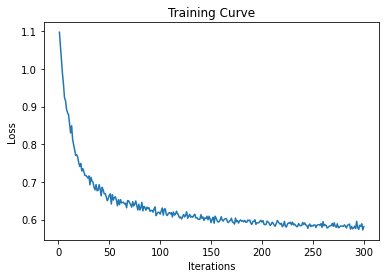

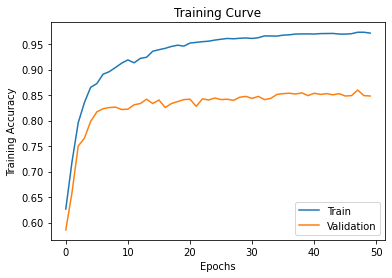

Final Training Accuracy: 0.9714619492656876
Final Validation Accuracy: 0.8481308411214953
The model took 396.61 seconds to train


In [21]:
net1 = dropout_CNN()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  net1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(net1, feature_train_set, feature_val_set, batch_size=1024, num_epochs=50, learning_rate = 0.0003, transfer=True)

In [ ]:
val_class = torchvision.datasets.DatasetFolder('/content/gdrive/My Drive/APS360/Project/Features/Validation/', 
                                                    loader=torch.load, extensions=('.tensor'))

val_class_loader = torch.utils.data.DataLoader(val_class, batch_size=1, 
                                           num_workers=1, shuffle=True)
def get_accuracy_111(model, data_loader, v_class):
  
  # for the later dropout model, use this to flag testing mode
  #model.eval()
  
  correct = 0
  total = 0
  for imgs, labels in data_loader:
    
    if labels == v_class: 
      # print(labels)

      # enable GPU
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

      output = model(imgs)

      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
  return correct / total




The accuracy on class <mask_weared_incorrect> is 0.8767441860465116


In [ ]:
val_incorrect_accuracy = get_accuracy_111(net4, val_class_loader, 0)
print(("The accuracy on class <mask_weared_incorrect> is {}").format(val_incorrect_accuracy))

The accuracy on class <mask_weared_incorrect> is 0.45799457994579945
